In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools as itr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from statsmodels.stats.proportion import proportions_ztest

sns.set_theme(style='white', palette='colorblind')

In [2]:
df = pd.read_csv('.data/logregression_data.csv', index_col=0)
df['logodds'] = np.log(df['odds'])
df = df.drop(labels=['odds', 'expected'], axis=1)
df = df[df['won'] != 0.5]
df['won'] = df['won'].astype(bool)
print(df.head())

             won  home0  away0  daygame0  travel0  miles0  home1  away1  \
ANA20006   False    1.0    0.0       0.0      0.0     0.0    1.0    0.0   
ANA20007    True    1.0    0.0       0.0      0.0     0.0    1.0    0.0   
ANA20009    True    1.0    0.0       0.0      0.0     0.0    0.0    0.0   
ANA200010   True    1.0    0.0       0.0      0.0     0.0    1.0    0.0   
ANA200011  False    1.0    0.0       1.0      0.0     0.0    1.0    0.0   

           daygame1  travel1  ...  away5  daygame5  travel5  miles5  home6  \
ANA20006        0.0      0.0  ...    0.0       0.0      0.0     0.0    0.0   
ANA20007        0.0      0.0  ...    0.0       0.0      0.0     0.0    0.0   
ANA20009        0.0      0.0  ...    0.0       0.0      0.0     0.0    0.0   
ANA200010       0.0      0.0  ...    0.0       0.0      0.0     0.0    0.0   
ANA200011       0.0      0.0  ...    0.0       0.0      0.0     0.0    1.0   

           away6  daygame6  travel6  miles6   logodds  
ANA20006     0.0       0

In [3]:
for var in df.columns:
    if var.startswith("travel"):
        df = df.drop(var, axis=1)
print(df.head())

             won  home0  away0  daygame0  miles0  home1  away1  daygame1  \
ANA20006   False    1.0    0.0       0.0     0.0    1.0    0.0       0.0   
ANA20007    True    1.0    0.0       0.0     0.0    1.0    0.0       0.0   
ANA20009    True    1.0    0.0       0.0     0.0    0.0    0.0       0.0   
ANA200010   True    1.0    0.0       0.0     0.0    1.0    0.0       0.0   
ANA200011  False    1.0    0.0       1.0     0.0    1.0    0.0       0.0   

           miles1  home2  ...  miles4  home5  away5  daygame5  miles5  home6  \
ANA20006      0.0    0.0  ...     0.0    0.0    0.0       0.0     0.0    0.0   
ANA20007      0.0    1.0  ...     0.0    0.0    0.0       0.0     0.0    0.0   
ANA20009      0.0    1.0  ...     0.0    0.0    0.0       0.0     0.0    0.0   
ANA200010     0.0    0.0  ...     0.0    1.0    0.0       0.0     0.0    0.0   
ANA200011     0.0    1.0  ...     0.0    1.0    0.0       0.0     0.0    1.0   

           away6  daygame6  miles6   logodds  
ANA20006     0.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=['won'], axis=1), df['won'], test_size=0.33, random_state=0)

In [5]:
mdl = LogisticRegressionCV(cv=5,
                           Cs=[10. ** ex for ex in np.arange(-5, 1, 0.5)],
                           random_state=0,
                           penalty='l1',
                           solver='liblinear')
mdl.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-05, 3.1622776601683795e-05, 0.0001,
                         0.00031622776601683794, 0.001, 0.0031622776601683794,
                         0.01, 0.03162277660168379, 0.1, 0.31622776601683794,
                         1.0, 3.1622776601683795],
                     cv=5, penalty='l1', random_state=0, solver='liblinear')

In [6]:
coef_names = list(df.columns)
coef_names.remove('won')
coef_sr = pd.Series(mdl.coef_[0], index=coef_names)

print(f'AUC (train): {mdl.score(X_train, y_train)}')
print(f'Significant vars: {sum([elm != 0 for elm in mdl.coef_[0]])}')
print(coef_sr)
print(mdl.C_)

AUC (train): 0.5883361454307952
Significant vars: 16
home0       0.219204
away0      -0.071660
daygame0    0.032442
miles0     -0.000014
home1      -0.035016
away1      -0.047375
daygame1    0.000000
miles1     -0.000030
home2      -0.001682
away2       0.000000
daygame2    0.000000
miles2     -0.000019
home3      -0.010695
away3       0.000000
daygame3    0.000000
miles3     -0.000014
home4       0.000000
away4       0.000000
daygame4    0.000000
miles4     -0.000010
home5       0.000000
away5      -0.016783
daygame5    0.000000
miles5      0.000003
home6       0.000000
away6       0.000000
daygame6    0.000000
miles6     -0.000015
logodds     0.974903
dtype: float64
[0.03162278]


0.5894426680659997


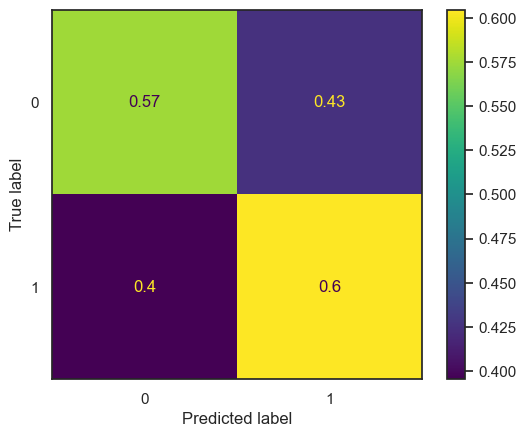

In [7]:
y_pred = mdl.predict(X_test)

print(metrics.roc_auc_score(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')
conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
conf_display.plot()
plt.show()

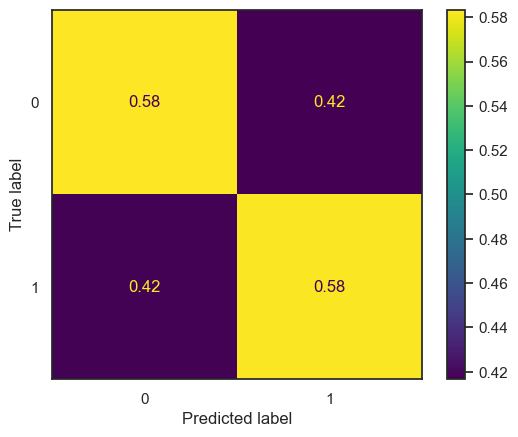

In [8]:
rating_pred = np.where(np.exp(df['logodds']) > 1, 1, 0)
confusion_matrix = metrics.confusion_matrix(df['won'], rating_pred, normalize='true')
conf_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
conf_display.plot()
plt.show()

In [9]:
correct = [np.sum(rating_pred == df['won']), np.sum(mdl.predict(df.drop(labels=['won'], axis=1)) == df['won'])]
total = [len(df.index), len(df.index)]
test_stat, pval = proportions_ztest(count=correct, nobs=total, alternative='smaller')
print(f'z = {test_stat}, pval = {pval}')

z = -2.778287084032435, pval = 0.00273231567882076


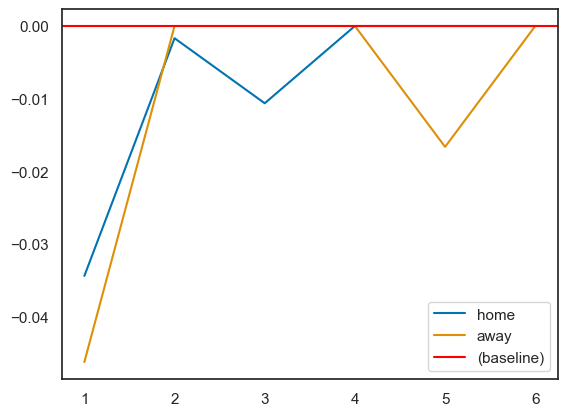

In [11]:
vis_df = pd.DataFrame(data=np.nan, index=range(1, 7), columns=['home', 'away'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df, dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()

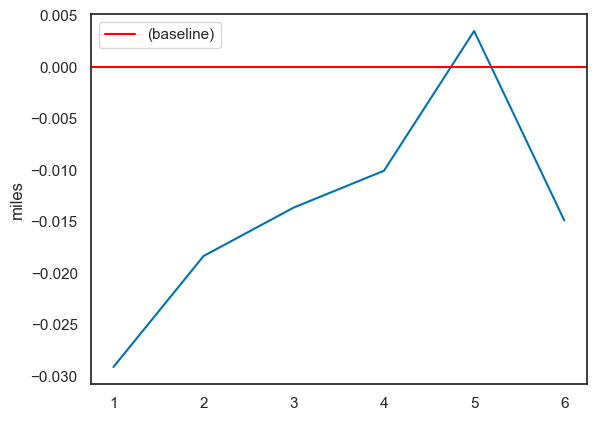

In [12]:
vis_df = pd.DataFrame(data=np.nan, index=range(1, 7), columns=['miles'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(1000 * coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df['miles'], dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()

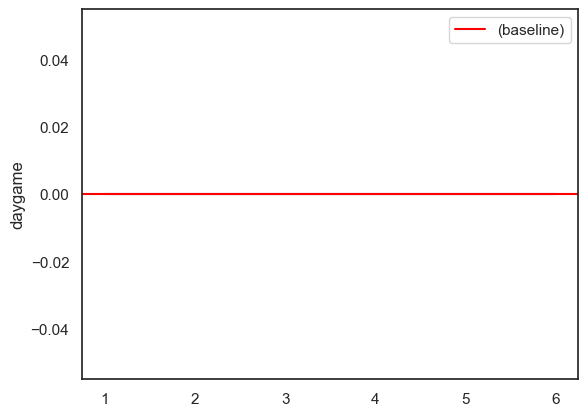

In [13]:
vis_df = pd.DataFrame(data=np.nan, index=range(1, 7), columns=['daygame'])
for delay in vis_df.index:
    for var in vis_df.columns:
        var_name = var + str(delay)
        vis_df.loc[delay, var] = np.exp(coef_sr.loc[var_name]) - 1
sns.lineplot(vis_df['daygame'], dashes=False)
plt.axhline(0, label='(baseline)', color='red')
plt.legend()
plt.show()